In [1]:
import os
import pandas as pd
import string
import random
import matplotlib
import numpy as np
import coremltools
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from keras import backend as K
from ast import literal_eval
from sklearn.utils import class_weight
from keras.models import Sequential
from keras.models import load_model
from keras.metrics import top_k_categorical_accuracy
from keras.callbacks import ModelCheckpoint
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, LeakyReLU
from keras import regularizers, optimizers
from livelossplot import PlotLossesKeras
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from PIL import ImageFile, Image


In [2]:
DATASET_PATH = "MAFood121\\images\\"
METADATA_PATH = "MAFood121\\metadata_win.csv"
IMAGE_PATH_KEY = "image_path"
LABELS_PATH_KEY = "label"
MODEL_PATH = "food-id-red3.h5"
IMAGE_SIZE = 224
BATCH_SIZE = 16
RANDOM_SEED = 115
EPOCHS = 25
TESTING_SIZE = 500
VALIDATION_SPLIT = 0.1
LEARNING_RATE = 0.0001
LEARNING_RATE_DECAY = LEARNING_RATE/100.0
CONFIDENCE_THRESHOLD = 0.9
ImageFile.LOAD_TRUNCATED_IMAGES = True
Image.MAX_IMAGE_PIXELS = 239200489

In [3]:
# Loading metadata and splitting into training/validation and testing sets
df = pd.read_csv(METADATA_PATH)

training_and_validation_size = df.shape[0] - TESTING_SIZE

training_df = df[:training_and_validation_size]
testing_df = df[training_and_validation_size:]

training_df[LABELS_PATH_KEY] = training_df[LABELS_PATH_KEY].apply(lambda x:literal_eval(x))
training_df

<ipython-input-3-9f420f2a59a6>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_df[LABELS_PATH_KEY] = training_df[LABELS_PATH_KEY].apply(lambda x:literal_eval(x))


,image_path,label
0,hunkar_begendi\240.jpg,[hunkar_begendi]
1,hunkar_begendi\21.jpg,[hunkar_begendi]
2,naan\49_1.jpg,[naan]
3,ravioli\2725271.jpg,[ravioli]
4,caprese_salad\2358715.jpg,[caprese_salad]
...,...,...
20670,souvlaki\85_2.jpg,[souvlaki]
20671,breakfast_burrito\805523.jpg,[breakfast_burrito]
20672,nachos\500252.jpg,[nachos]
20673,omelette\800743.jpg,[omelette]


In [4]:
# Getting labels
all_labels = [] 

for tags in training_df[LABELS_PATH_KEY].values.tolist():
    for tag in tags:
        all_labels.append(tag)
        
unique_labels = list(np.unique(all_labels))

In [5]:
training_data_generator = ImageDataGenerator(rotation_range=30,
                                             zoom_range=0.2,
                                             width_shift_range=0.2,
                                             height_shift_range=0.2,
                                             shear_range=0.2,
                                             horizontal_flip=True,
                                             fill_mode="nearest",
                                             validation_split=VALIDATION_SPLIT,
                                             preprocessing_function=preprocess_input)

training_generator = training_data_generator.flow_from_dataframe(dataframe=training_df,
                                                                 directory=DATASET_PATH,
                                                                 x_col=IMAGE_PATH_KEY, 
                                                                 y_col=LABELS_PATH_KEY,
                                                                 batch_size=BATCH_SIZE,
                                                                 seed=RANDOM_SEED,
                                                                 class_mode="categorical",
                                                                 target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                                 subset="training")

validation_generator = training_data_generator.flow_from_dataframe(dataframe=training_df,
                                                                   directory=DATASET_PATH,
                                                                   x_col=IMAGE_PATH_KEY,
                                                                   y_col=LABELS_PATH_KEY,
                                                                   batch_size=BATCH_SIZE,
                                                                   seed=RANDOM_SEED,
                                                                   class_mode="categorical",
                                                                   target_size=(IMAGE_SIZE, IMAGE_SIZE), 
                                                                   subset="validation")


Found 18608 validated image filenames belonging to 121 classes.
Found 2067 validated image filenames belonging to 121 classes.


In [6]:
def model():
    def model(backbone):
        model = Sequential()
        model.add(backbone)
        model.add(GlobalAveragePooling2D())
        model.add(BatchNormalization())
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.3))
        model.add(Dropout(.5))
        model.add(Dense(128))
        model.add(LeakyReLU(alpha=0.3))
        #model.add(Dropout(.5))
        #model.add(Dense(1024, activation='relu'))
        #model.add(Dense(1024, activation='relu'))
        #model.add(Dense(512, activation='relu'))
        #model.add(Dense(512, activation='relu'))
        #model.add(Dense(256, activation='relu'))
        model.add(Dense(len(unique_labels), activation='sigmoid'))
        model.compile(loss='categorical_crossentropy',
                      optimizer=optimizers.Adam(lr=LEARNING_RATE, decay=LEARNING_RATE_DECAY),
                      metrics=["accuracy"])
        return model

    backbone = MobileNetV2(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')
    backbone.trainable = False
    return model(backbone)


model = model()

In [7]:
# Setting class weights to handle imbalanced data
'''
class_weights = class_weight.compute_class_weight('balanced',
                                                  unique_labels,
                                                  all_labels)

'''
#class_weights = dict(enumerate(class_weights))

"\nclass_weights = class_weight.compute_class_weight('balanced',\n                                                  unique_labels,\n                                                  all_labels)\n\n"

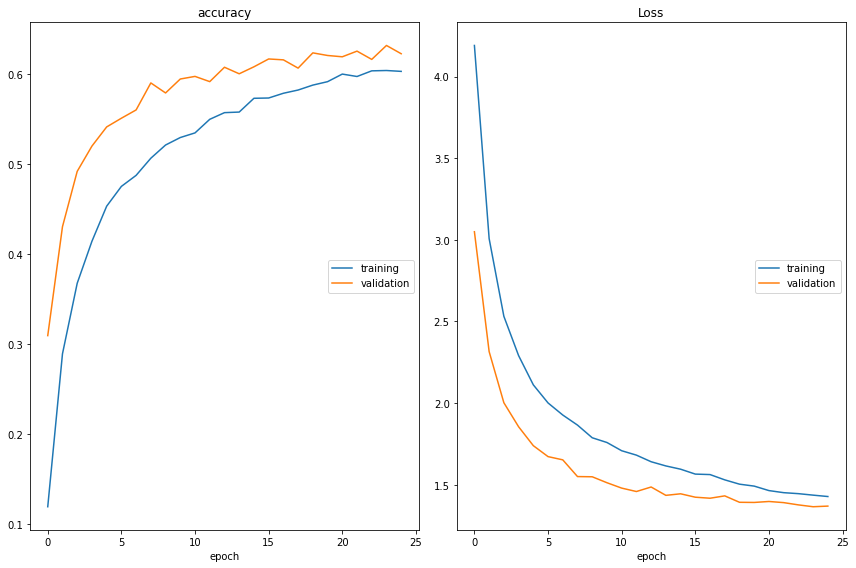

accuracy
	training         	 (min:    0.119, max:    0.604, cur:    0.603)
	validation       	 (min:    0.310, max:    0.632, cur:    0.623)
Loss
	training         	 (min:    1.428, max:    4.190, cur:    1.428)
	validation       	 (min:    1.365, max:    3.050, cur:    1.369)

Epoch 00025: val_accuracy did not improve from 0.63227


In [8]:
# Training
model.fit_generator(generator=training_generator,
                    #class_weight=class_weights,
                    steps_per_epoch=training_generator.n // training_generator.batch_size,
                    validation_data=validation_generator,
                    validation_steps=validation_generator.n // validation_generator.batch_size,
                    callbacks=[PlotLossesKeras(), 
                               ModelCheckpoint(MODEL_PATH,
                                               monitor='val_accuracy',
                                               mode='max',
                                               save_best_only=True,
                                               verbose=1)],
                    epochs=EPOCHS)
model = load_model(MODEL_PATH)

In [9]:
# Testing
testing_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
testing_generator = testing_data_generator.flow_from_dataframe(dataframe=testing_df,
                                                               directory=DATASET_PATH,
                                                               x_col=IMAGE_PATH_KEY,
                                                               batch_size=1,
                                                               seed=RANDOM_SEED,
                                                               shuffle=False,
                                                               class_mode=None,
                                                               target_size=(IMAGE_SIZE, IMAGE_SIZE))
predictions = model.predict_generator(testing_generator,
                                      steps=testing_generator.n,
                                      verbose=1)

Found 500 validated image filenames.


c:\users\eric_\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\engine\training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


500/500 [==============================] - 8s 16ms/step


In [10]:
for prediction in predictions:
    print(prediction)

[1.0691553e-02 4.1594481e-01 2.6426971e-01 2.9614866e-03 1.0734987e-01
 9.6377420e-01 9.9883139e-01 2.7918816e-04 1.6154349e-03 2.9035509e-03
 1.2670696e-02 9.5727217e-01 1.4483324e-01 6.7259693e-01 7.5097692e-01
 8.0369270e-01 9.6907651e-01 7.3872232e-01 9.9873877e-01 1.9654036e-03
 3.3833539e-01 1.4154911e-03 1.8465111e-01 8.6509275e-01 4.2239189e-02
 5.5364072e-03 1.1345896e-01 8.2358122e-03 8.6483985e-02 8.6315298e-01
 6.8322098e-01 2.5639105e-01 1.7129385e-01 2.5098169e-01 5.8898765e-01
 9.3511909e-01 3.3547282e-03 1.1267534e-01 9.8704714e-01 9.5456022e-01
 9.5088446e-01 7.2041398e-01 8.6752558e-01 7.5015426e-04 2.0073801e-02
 8.4536672e-03 2.8225183e-03 9.1253412e-01 5.3270161e-03 2.3679867e-01
 2.1027669e-01 5.7655573e-03 2.1984577e-03 8.2200766e-04 2.6857257e-02
 2.8554523e-01 1.8066311e-01 2.2120476e-03 5.3091049e-03 9.0098858e-01
 4.7303438e-03 4.0110260e-02 7.4983120e-02 3.2029206e-01 1.5881658e-04
 7.2427005e-02 8.8453352e-02 1.4080107e-03 5.1388144e-04 2.6128858e-02
 3.074

 1.90073252e-03]
[9.8672586e-05 9.1961861e-01 1.1290933e-06 1.0759940e-04 1.3870001e-04
 9.9975127e-01 2.3916662e-03 6.2651084e-10 1.1417568e-03 3.0177976e-06
 9.9540448e-01 9.9993575e-01 8.1571937e-04 2.0856827e-02 8.3161485e-01
 4.1990512e-05 1.0000000e+00 4.1380793e-02 2.5171107e-01 7.8306782e-01
 3.5822988e-03 9.5470208e-01 1.7077741e-07 5.9723191e-09 2.1846890e-03
 9.8815233e-02 9.8808706e-03 3.5157800e-03 1.1085749e-02 5.4273427e-02
 5.9536409e-01 1.1205971e-03 9.9935305e-01 9.9999654e-01 3.2718122e-02
 9.9999130e-01 1.0483861e-02 5.4088588e-07 1.2786711e-05 9.9282742e-01
 1.8835962e-03 9.9996543e-01 5.6143594e-01 9.1160893e-02 1.3668537e-03
 8.0526191e-01 1.4138192e-07 1.2029469e-02 1.9073232e-05 1.2892087e-05
 9.9879038e-01 4.5550178e-06 1.0705471e-02 2.1196654e-05 2.1887139e-05
 4.3477528e-05 1.8227578e-07 6.6673110e-06 2.4521351e-04 6.0836584e-05
 9.5476562e-01 1.8586278e-01 2.6691866e-01 1.2269214e-01 3.4184845e-06
 6.8956017e-03 7.1004033e-04 3.2634139e-03 1.1482069e-06 2.1

 2.85327435e-04]
[9.11040664e-01 2.48040557e-01 2.15042770e-01 7.24280357e-01
 4.13194299e-03 8.30499589e-01 4.15564239e-01 1.37380123e-01
 2.30254233e-02 9.99930203e-01 1.16253197e-02 2.11090446e-02
 4.91580367e-03 2.13851333e-02 4.94181901e-01 1.80281699e-02
 1.46272779e-03 8.80695879e-01 2.93218344e-01 7.23704696e-02
 9.23736453e-01 1.13797784e-02 8.84807110e-03 8.17985415e-01
 1.00000000e+00 2.27165222e-03 6.65690899e-01 5.83205521e-02
 2.27857232e-02 2.41132259e-01 3.73505354e-02 9.90480185e-04
 8.36321115e-02 1.06644630e-03 8.42755795e-01 8.70708466e-01
 2.47836113e-04 2.09754407e-02 2.02464640e-01 1.51314348e-01
 2.55386531e-02 7.11199641e-03 5.64665496e-02 6.52252138e-02
 1.21980369e-01 3.68685484e-01 9.99751449e-01 9.98705626e-04
 2.64135003e-03 4.87446785e-04 1.74131989e-03 9.46759462e-01
 9.97336626e-01 8.83720279e-01 3.69452834e-02 9.99940395e-01
 6.24155998e-03 9.88957942e-01 7.53388703e-02 9.29182768e-03
 2.19216347e-02 6.09914660e-02 8.05872083e-02 2.73493230e-02
 9.8736

 2.2241628e-01]
[7.20128417e-03 7.78407454e-01 9.12634860e-05 2.60114670e-03
 1.37984157e-02 8.76063406e-02 8.48750293e-01 1.69786245e-01
 1.19227171e-02 1.29887462e-03 8.71177375e-01 2.56263673e-01
 5.70994020e-02 3.59830797e-01 5.45979738e-01 2.22307146e-02
 9.66021419e-03 1.32010281e-02 4.35834646e-01 4.13834333e-01
 4.16038513e-01 2.32006678e-05 1.20465159e-02 4.13394570e-02
 5.90443611e-04 1.95262790e-01 1.69277489e-02 4.60713059e-01
 6.26763701e-03 1.00497603e-01 2.43817896e-01 1.16164386e-01
 2.95563102e-01 1.48422509e-01 7.02650547e-01 2.73534209e-01
 9.20912504e-01 9.88562405e-01 8.57904673e-01 9.75312948e-01
 2.10160553e-01 4.10041213e-02 3.01362395e-01 4.09592986e-02
 2.89350748e-04 1.36364758e-01 1.40011311e-04 9.09915566e-01
 9.45927262e-01 3.80533576e-01 9.80949938e-01 1.03360236e-01
 1.98125839e-04 4.86472249e-03 1.59189701e-02 5.10782003e-04
 9.33816671e-01 1.22997386e-04 1.37526989e-02 1.16514862e-02
 9.94858503e-01 1.47509336e-01 3.80255699e-01 5.11720777e-02
 2.52306

 4.6738982e-04]
[3.96004319e-03 8.36390495e-01 2.91064382e-01 2.53202617e-02
 8.76625419e-01 1.93370193e-01 7.02378273e-01 1.77827477e-03
 4.13820416e-01 6.56217337e-04 7.99613476e-01 3.16963196e-01
 9.65651751e-01 1.12620503e-01 6.50274992e-01 9.66177821e-01
 3.38959754e-01 5.07046819e-01 3.64525914e-02 6.04252100e-01
 2.65971720e-01 7.73315072e-01 2.31677294e-02 5.80006838e-03
 7.11788237e-02 1.16811514e-01 3.20534199e-01 5.13353944e-02
 2.05034345e-01 6.40793800e-01 8.35312009e-01 9.34988976e-01
 4.69523549e-01 3.85878563e-01 5.24369776e-02 9.29501176e-01
 2.90152609e-01 2.91850567e-02 6.53356314e-04 2.11579323e-01
 2.32458979e-01 8.18451643e-01 2.59823024e-01 8.94055247e-01
 9.84054565e-01 8.13726544e-01 5.66691160e-04 2.50327587e-03
 1.60312355e-02 3.45165402e-01 7.82574892e-01 1.58005953e-03
 4.20868397e-03 4.29555774e-03 1.15327895e-01 1.51799053e-01
 2.31478512e-02 1.51309371e-03 2.10400432e-01 9.06854868e-04
 8.61079395e-02 3.10181379e-02 5.12184560e-01 6.68015778e-02
 2.18608

 2.4863094e-02]
[1.6957521e-04 7.0883220e-01 7.7512860e-04 5.1646531e-02 6.5317690e-05
 9.9169517e-01 5.7333410e-03 1.2270056e-07 7.2319776e-02 7.6119235e-05
 9.7165859e-01 9.9396038e-01 4.1204065e-01 1.9608617e-02 9.9332738e-01
 7.0302272e-01 9.9977189e-01 4.5727763e-01 7.5198352e-01 8.8258725e-01
 6.0263872e-03 2.5245351e-01 1.1898279e-03 1.7351285e-06 1.0867056e-01
 3.2447433e-01 9.4366449e-01 1.0920376e-02 2.2503376e-02 6.2331641e-01
 2.7405441e-02 1.4230624e-05 9.6133441e-01 9.8909903e-01 6.3374758e-02
 9.8929113e-01 3.6251545e-04 3.4415722e-04 2.1537542e-03 9.8430544e-01
 2.6467174e-02 9.8915535e-01 6.4763129e-03 7.8578913e-01 1.8416345e-02
 9.8727715e-01 2.4365901e-05 4.7077835e-03 9.4696879e-04 3.4129620e-04
 8.9862907e-01 1.0477901e-03 9.5852911e-03 2.6947030e-06 1.9831973e-06
 2.4089217e-04 1.4430285e-04 8.0146987e-05 7.4216962e-02 1.1379719e-03
 3.1790394e-01 2.1994153e-01 9.7800791e-01 1.2769073e-02 5.9165955e-03
 1.7586917e-02 1.6616285e-03 3.2075256e-02 4.6567024e-05 9.35

 4.43500996e-01]
[1.3165563e-02 5.9350818e-02 3.2144189e-03 3.3665258e-01 6.4123631e-02
 2.7220100e-02 6.8631852e-01 2.2700611e-01 2.7778685e-02 3.5807788e-03
 7.0000362e-01 4.5278758e-02 2.4503970e-01 2.0491812e-01 9.6847445e-01
 6.8659145e-01 2.8193057e-02 7.9139984e-01 1.4228374e-02 9.0926206e-01
 2.8484291e-01 7.5863600e-03 3.1251502e-01 3.1796783e-02 8.3042681e-03
 1.0432434e-01 2.3714811e-02 7.6216966e-01 5.9566021e-02 1.3903031e-01
 2.9052514e-01 3.2054216e-02 5.7201147e-02 8.4978938e-03 2.5234812e-01
 4.7149038e-01 1.2715009e-01 8.2213253e-01 1.4109144e-01 3.0775690e-01
 9.4918513e-01 6.3730890e-01 7.8361368e-01 9.4058800e-01 6.9267809e-02
 3.7975699e-02 3.4310818e-03 5.2946001e-02 9.0473771e-02 4.7802085e-01
 9.4774938e-01 1.0488659e-02 1.0576844e-03 3.0754626e-02 2.1861655e-01
 2.2664964e-03 9.5033467e-02 2.3552477e-03 7.6414716e-01 4.7887564e-03
 1.3826925e-01 2.0925999e-03 1.4027417e-02 4.8610541e-01 4.5352578e-03
 9.9586594e-01 1.3058186e-03 3.0065447e-02 3.5410583e-01 5.4

 8.94863725e-01]
[1.35907531e-03 9.17440534e-01 4.72044048e-05 3.36157680e-02
 3.34498945e-05 3.06927562e-02 8.27610493e-04 1.00434561e-04
 2.62165070e-02 1.68033540e-02 9.04241621e-01 3.96497399e-01
 8.16196203e-04 6.91136718e-03 2.42747366e-02 3.63320112e-04
 1.02953643e-01 2.48804688e-03 1.47830427e-01 9.65058923e-01
 6.23350143e-02 2.24858522e-04 1.61705613e-02 2.03032027e-06
 4.79718728e-05 9.99550223e-01 2.79511034e-01 3.27487677e-01
 9.03740168e-01 1.00376010e-02 3.19026083e-01 1.65194273e-03
 9.98330712e-01 9.91369963e-01 2.13311017e-02 8.70489120e-01
 9.99999642e-01 1.04167223e-01 3.59654427e-04 8.63358855e-01
 3.80516052e-04 6.92337751e-03 3.28398585e-01 3.46885145e-01
 2.52044201e-03 9.80347872e-01 4.95998429e-05 2.60718524e-01
 9.86117721e-01 8.69929790e-04 9.95272696e-01 1.67071819e-04
 3.11523676e-04 1.87098980e-04 2.23033130e-02 3.72687173e-05
 2.19089389e-02 2.84735592e-07 4.24772501e-04 3.34800243e-05
 9.86064792e-01 9.62196410e-01 5.98618805e-01 2.79089212e-02
 2.0780

 0.38512498]
[9.93250724e-05 9.91970778e-01 8.85865092e-03 6.53296709e-04
 1.51348613e-05 4.10171509e-01 1.39950693e-01 2.53099506e-06
 1.15596609e-04 1.62738562e-03 9.02076483e-01 9.75120783e-01
 7.30961561e-04 1.58077151e-01 6.00705147e-01 8.60522509e-01
 5.13178229e-01 2.05190539e-01 9.99978781e-01 8.04241180e-01
 6.97659969e-01 4.54097986e-04 2.66402960e-04 3.36080790e-04
 6.22054935e-03 1.28084540e-01 9.99616206e-01 4.75236773e-03
 1.07379623e-04 3.32748592e-02 4.62194681e-02 5.20456670e-05
 9.76927459e-01 9.78255510e-01 8.56014013e-01 3.38300228e-01
 1.15674734e-03 5.57759404e-03 9.85860288e-01 9.51277614e-01
 1.06835485e-01 7.42216468e-01 4.24259901e-03 6.45581782e-02
 3.57958615e-01 9.99232769e-01 3.16224323e-05 2.06225157e-01
 8.92775059e-02 4.21524048e-04 9.51328039e-01 4.99039888e-04
 7.27301836e-03 2.40835448e-07 2.55930991e-05 7.08162785e-04
 1.35303319e-01 4.07167090e-06 3.25769186e-04 6.54961348e-01
 1.22262776e-01 3.63413572e-01 9.99922276e-01 1.84968114e-03
 9.13590193

 8.5479343e-01]
[5.8011085e-02 2.5749385e-01 7.9065263e-03 3.8739684e-01 7.7627599e-03
 3.2598317e-01 4.4232953e-01 5.4855645e-02 6.8039131e-01 2.4703145e-03
 6.1053121e-01 2.9894489e-01 2.9619423e-01 1.7420867e-01 9.9487257e-01
 8.3731377e-01 3.0666089e-01 3.3403367e-02 2.0192277e-01 8.2969916e-01
 9.9859595e-01 1.2974232e-02 5.5486262e-03 8.5661113e-03 1.0809946e-01
 6.0870349e-03 2.1810204e-02 5.1896721e-01 4.0073872e-02 8.4615099e-01
 2.7914494e-02 4.1934550e-03 1.1908251e-01 3.8112450e-01 9.6956897e-01
 2.5099099e-02 3.4967065e-04 8.9037871e-01 2.0005774e-01 7.8604460e-02
 9.8903042e-01 9.9463338e-01 5.9379423e-01 8.1764400e-01 5.3571665e-01
 2.8849632e-02 1.2123585e-03 6.0373366e-02 1.6099811e-03 2.4712628e-01
 9.8137093e-01 9.2271000e-02 3.6314130e-03 6.8652630e-03 3.5351813e-03
 1.7127919e-01 3.0272245e-01 1.9313186e-02 2.8719962e-02 1.1828929e-02
 1.0083023e-01 8.1271827e-03 7.8078830e-01 1.8231601e-02 1.7519063e-01
 4.4460380e-01 1.9019157e-02 7.2645545e-03 2.2083402e-02 2.82